# Classification from 2 features

Classification using "raw" python or libraries.
The classification is first on a single boundary (single class) defined by a continuous function and added white noise

In [1]:
import tensorflow as tf
import math
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics as skMetrics
import scikitplot as skplt
import scipy as sy
import pandas

## Model

Quadratic function a boundary between positive and negative values

Adding some unknown as a Gaussian noise

In [2]:
# Single feature, Gaussian noise
def generateBatch(N):
    #
    xMin = 0
    xMax = 1
    b = 0.1
    std = 0.1
    #
    x = random.uniform(xMin, xMax, (N, 2))
    # 4th degree relation to shape the boundary
    boundary = 2*(x[:,0]**4 + (x[:,0]-0.3)**3 + b)
    # Adding some gaussian noise
    labels = boundary + random.normal(0, std, N) > x[:,1]
    return (x, labels)

The values of X are uniformly distributed and independent

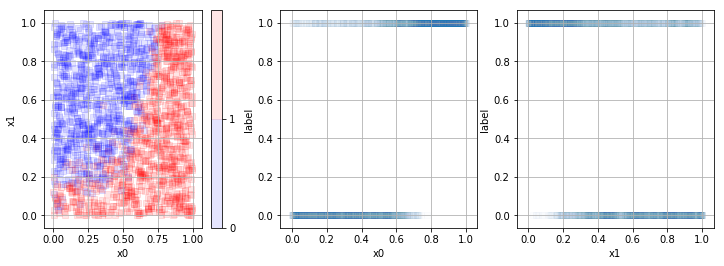

In [3]:
N = 2000
# x and y have 1 dim in R, label has 1 dim in B
xTrain, labelTrain = generateBatch(N)

colors = ['blue','red']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.scatter(xTrain[:,0], xTrain[:,1], c=labelTrain, cmap=pltcolors.ListedColormap(colors), marker=',', alpha=0.1)
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1])
plt.subplot(1,3,2)
plt.scatter(xTrain[:,0], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x0')
plt.ylabel('label')
plt.grid()
plt.subplot(1,3,3)
plt.scatter(xTrain[:,1], labelTrain, marker=',', alpha=0.01)
plt.xlabel('x1')
plt.ylabel('label')
plt.grid()

Bernouilli parameter of the distribution: 0.512


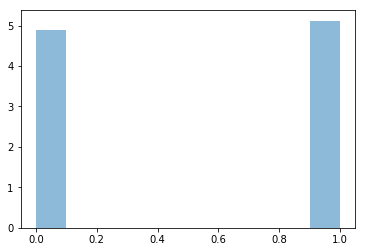

In [4]:
count, bins, ignored = plt.hist(labelTrain, 10, density=True, alpha=0.5)
p = np.mean(labelTrain)
print('Bernouilli parameter of the distribution:', p)

### Test data for verification of the model

In [5]:
xTest, labelTest = generateBatch(N)

# Using TensorFlow

Reference:
- Inspired from https://www.geeksforgeeks.org/ml-logistic-regression-using-tensorflow/ BUT 
    - This example is mixing symbols and values. 
    - For example redefining several times the cost, prediction and accuracy
    - It is actualy quite inefficient
    - There is no verification of the model through a test sample
    - Modifications were also necessary to remove 1 dimension in the features/predictors

In [6]:
# Labels as float {0,1}
labelTrainF = np.multiply(labelTrain, 1.0)
labelTrainF.dtype

dtype('float64')

In [7]:
# Batch size, learning rate, epochs
nBatch = 1000
alpha = 0.05
nEpoch = 10000
nFeatures = 2
# x and y are placeholders for our training data
X = tf.placeholder("float64", [None, nFeatures], name='X')
Y = tf.placeholder("float64", [None, 1], name='Y')
# Initial weights and intercept
Wtf = tf.Variable(tf.zeros((nFeatures, 1), tf.float64), name='W')
Btf = tf.Variable(tf.ones(1, tf.float64), name='b')
# Our model of y = sigmoid(a*x + b)
Y_model = tf.sigmoid(tf.matmul(X, Wtf) + Btf)
# Sigmoid Cross Entropy Cost Function 
Cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_model, labels = Y) 
# Prediction & Accuracy
CorrectPrediction = tf.equal(tf.greater(Y_model, 0.5), tf.greater(Y, 0.5))
Accuracy = tf.reduce_mean(tf.cast(CorrectPrediction, tf.float64))
  
# Gradient Descent Optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate = alpha).minimize(Cost) 

# Global Variables Initializer 
init = tf.global_variables_initializer() 

W0719 12:15:22.612566 140735793488768 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Initializing the session and model 
sess = tf.Session() 
sess.run(init) 

# List storing the evolution through epochs 
histo = []

# Iterating through all the epochs 
for epoch in range(nEpoch+1): 

    # Running the Optimizer 
    # Calculating cost, accuracy on current Epoch 
    xBatch, labelBatch = generateBatch(nBatch)
    labelBatchF = np.multiply(labelBatch, 1.0)
    _, c, b, w, accu = sess.run([optimizer, Cost, Btf, Wtf, Accuracy], feed_dict={X: xBatch, Y: labelBatchF.reshape(-1,1)}) 
                                # feed_dict = {X : xTrain, Y : labelTrainF}) 

    # Save history 
    histo.append([np.sum(c), accu, b, w[0], w[1]])

    # Displaying result on current Epoch 
    if epoch % 1000 == 0 and epoch != 0: 
       hNow = histo[-1]
       print("Epoch", epoch, " Cost:", hNow[0], " Accuracy:", hNow[1], "b:", hNow[2], "W:", hNow[3], ',', hNow[4]) 

# Save history as a Panda Data Frame
df = pandas.DataFrame(histo, columns = ('cost', 'accuracy', 'b', 'w0', 'w1'))

Epoch 1000  Cost: 552.8163123374952  Accuracy: 0.889 b: [-4.80230684] W: [18.6079214] , [-11.06239496]
Epoch 2000  Cost: 548.5593246150851  Accuracy: 0.913 b: [-7.3199347] W: [26.66307492] , [-15.28330684]
Epoch 3000  Cost: 547.6453323491418  Accuracy: 0.891 b: [-9.45842939] W: [33.37790923] , [-18.40271505]
Epoch 4000  Cost: 537.7782987521892  Accuracy: 0.895 b: [-11.15610228] W: [39.13284273] , [-21.43811178]
Epoch 5000  Cost: 544.808662313603  Accuracy: 0.889 b: [-12.83696832] W: [44.26260512] , [-23.90139205]
Epoch 6000  Cost: 535.4998969597224  Accuracy: 0.914 b: [-14.34359489] W: [48.88210571] , [-25.97615672]
Epoch 7000  Cost: 548.4546855934086  Accuracy: 0.878 b: [-15.68351851] W: [52.99011548] , [-27.6629076]
Epoch 8000  Cost: 542.2321388472699  Accuracy: 0.885 b: [-16.91509719] W: [56.35151584] , [-29.48844948]
Epoch 9000  Cost: 545.3837911136781  Accuracy: 0.889 b: [-17.64345256] W: [59.24138406] , [-31.47088311]
Epoch 10000  Cost: 544.7535741236677  Accuracy: 0.889 b: [-18.

In [9]:
bEst = df['b'][len(df['b'])-1]
wEst = np.array([df['w0'][len(df['w0'])-1], df['w1'][len(df['w1'])-1]]).reshape(-1)
print('Estimated b=', bEst, ', w=', wEst)

Estimated b= [-18.77005103] , w= [ 61.92889982 -32.42496945]


The accuracy is quickly reaching a good level. 

However, the gradient is not reaching 0 and the solution is not unique, the coefficients are still evolving with epochs

Text(0.5, 1.0, 'Accuracy')

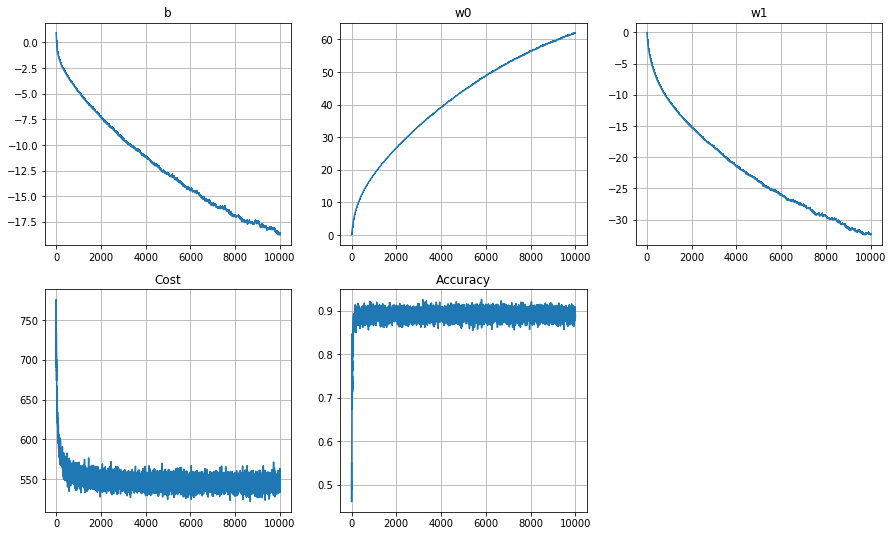

In [10]:
plt.figure(figsize=(15,9))
plt.subplot(2,3,1)
plt.plot(df['b'], marker=',');
plt.title('b')
plt.grid()
plt.subplot(2,3,2)
plt.plot(df['w0'], marker=',');
plt.title('w0')
plt.grid()
plt.subplot(2,3,3)
plt.plot(df['w1'], marker=',');
plt.title('w1')
plt.grid()
plt.subplot(2,3,4)
plt.plot(df['cost'])
plt.grid()
plt.title('Cost')
plt.subplot(2,3,5)
plt.plot(df['accuracy'])
plt.grid()
plt.title('Accuracy')

## Testing the model

In [11]:
yEst = sess.run(Y_model, feed_dict ={X: xTest, Y: np.multiply(labelTest, 1.0).reshape(-1,1)}) 
sess.close()

In [12]:
labelEst = (yEst > 0.5).reshape(-1)

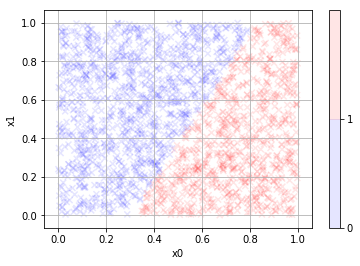

In [13]:
plt.scatter(xTest[:,0], xTest[:,1], c=labelEst, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.1);
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
cb = plt.colorbar()
loc = np.arange(0,1,1./len(colors))
cb.set_ticks(loc)
cb.set_ticklabels([0,1]);

Bernouilli parameter = 0.4395


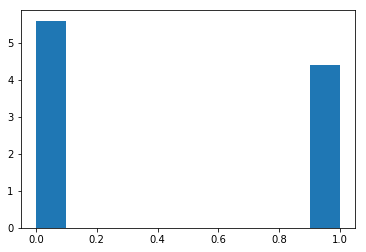

In [14]:
plt.hist(labelEst, 10, density=True)
print('Bernouilli parameter =', np.mean(labelEst))

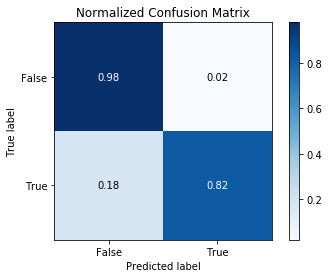

In [15]:
skplt.metrics.plot_confusion_matrix(labelTest, labelEst, normalize=True);

In [16]:
print(skMetrics.classification_report(labelTest, labelEst))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90       961
        True       0.97      0.82      0.89      1039

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000

